In [1]:
import copy
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
seed=0
import random
random.seed(seed)
import torch
torch.manual_seed(seed)
X_train = pd.read_csv('datamart/X_train_clipped_scaled.csv').values
y_train = pd.read_csv('datamart/y_lactose_train.csv').values
X_test = pd.read_csv('datamart/X_test_clipped_scaled.csv').values
y_test = pd.read_csv('datamart/y_lactose_test.csv').values

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [2]:
# def nn_cross_validation(X_train, y_train, model, loss, optimizer_name, lr=None, n_epochs=1000, batch_size=10, patience=10, kf=None, log=False, id=None ):

#     if log:
#         name = 'logs/NN/' + f'{id}' + '_random_search.csv'
#         with open(name, 'w', newline='\n') as csvfile:
#             w = csv.writer(csvfile, delimiter=';')
#             w.writerow(['id']+['fold']+['best_score']+['best_generations'])
    

#     results = []
#     model_wts = copy.deepcopy(model.state_dict())
    
#     for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
#         X_train_cross, X_val = X_train[train_index], X_train[val_index]
#         y_train_cross, y_val = y_train[train_index], y_train[val_index]
        
#         model.load_state_dict(model_wts)   
#         optimizer = get_optimizer(model.parameters(),optimizer_name, lr=lr)
        
        
#         best_epoch = 0
#         best_mse = np.inf
        
#         batch_start = torch.arange(0, len(X_train_cross), batch_size)
        
#         for epoch in range(n_epochs):
#             model.train()
#             with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#                 bar.set_description(f"Epoch {epoch}")
#                 for start in bar:
#                     # Take a batch
#                     X_batch = X_train_cross[start:start+batch_size]
#                     y_batch = y_train_cross[start:start+batch_size]
#                     # Forward pass
#                     y_pred = model(X_batch)
#                     loss = loss_fn(y_pred, y_batch)
#                     loss.backward()
#                     # Backward pass
#                     optimizer.step()
#                     optimizer.zero_grad()
                    
#                     # Update weights
                    
#                     # Print progress
#                     bar.set_postfix(mse=float(loss))
            
#             # Evaluate accuracy at end of each epoch
#             model.eval()
#             y_pred = model(X_val)
#             mse = loss_fn(y_pred, y_val)
#             mse = float(mse)
            
#             if mse < best_mse:
#                 best_mse = mse
#                 best_epoch = epoch
                
#             elif epoch - best_epoch >= patience:
#                 print(f"Early stopping at epoch {epoch}")
#                 break
        
#         if log:
#             name = 'logs/NN/' + f'{id}'+ '_random_search.csv'
#             with open(name, 'a', newline='\n') as csvfile:
#                 w = csv.writer(csvfile, delimiter=';')
#                 w.writerow([id]+[fold]+[best_mse]+[best_epoch])
        
#         for layer in model.children():
#             if hasattr(layer, 'reset_parameters'):
#                 layer.reset_parameters()
        
        
        
#         #print(model.forward(X_test)[:, 0])
#         results.append(best_mse)
        
#     avg_mse = np.mean(results)
#     print(avg_mse)
#     return avg_mse
        

    

In [3]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [4]:
def nn_cross_validation(X_train, y_train, model, loss, optimizer_name, lr=None, weight_decay=0.0, n_epochs=1000, batch_size=10,  kf=None, log=False, id=None ):

    if log:
        name = 'logs/NN/' + f'{id}' + '_random_search.csv'
        with open(name, 'w', newline='\n') as csvfile:
            w = csv.writer(csvfile, delimiter=';')
            w.writerow(['id']+['fold']+['best_score']+['best_generations'])
    

    results = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_train_cross, X_val = X_train[train_index], X_train[val_index]
        y_train_cross, y_val = y_train[train_index], y_train[val_index]
        
        model.apply(reset_weights)  
        optimizer = get_optimizer(model.parameters(),optimizer_name, lr=lr, weight_decay=weight_decay)
        
        
        best_epoch = 0
        best_mse = np.inf
        
        batch_start = torch.arange(0, len(X_train_cross), batch_size)
        
        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # Take a batch
                    X_batch = X_train_cross[start:start+batch_size]
                    y_batch = y_train_cross[start:start+batch_size]
                    # Forward pass
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()
                    # Backward pass
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    # Update weights
                    
                    # Print progress
                    bar.set_postfix(mse=float(loss))
            
            # Evaluate accuracy at end of each epoch
            model.eval()
            y_pred = model(X_val)
            mse = loss_fn(y_pred, y_val)
            mse = float(mse)
            

        
        
        
        
        if log:
            name = 'logs/NN/' + f'{id}'+ '_random_search.csv'
            with open(name, 'a', newline='\n') as csvfile:
                w = csv.writer(csvfile, delimiter=';')
                w.writerow([id]+[fold]+[mse]+[epoch])
        
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        
        
        #print(model.forward(X_test)[:, 0])
        results.append(mse)
        
    avg_mse = np.mean(results)
    print(avg_mse)
    return avg_mse
        

    

In [5]:
def create_model():
    return nn.Sequential(
        nn.Linear(12, 1),
        nn.Linear(1, 1),

    )

def eval_model(model, X_test, y_test):
    pred = model.forward(X_test)[:, 0]
    return mean_squared_error(y_test, pred)

def create_random_model():
    n_neurons_1 = random.randint(1,10)
    n_neurons_2 = random.randint(1,10)
    r1 = random.uniform(0,1)
    r2 = random.uniform(0,1)
    model = nn.Sequential(nn.Linear( 12, n_neurons_1))
    
    if r1 < 0.25:
        model.add_module('relu1', nn.ReLU())
        
    elif 0.25 < r1< 0.5:
        model.add_module('sigmoid1', nn.Sigmoid())
    
    if 0.5 < r1 < 0.75:
        model.add_module('linear', nn.Linear(n_neurons_1, n_neurons_2))
        
        if r2 < 0.25:
            model.add_module('relu2', nn.ReLU())
        elif 0.25 < r2 < 0.5:
            model.add_module('sigmoid2', nn.Sigmoid())
        model.add_module('output', nn.Linear(n_neurons_2, 1))
        return model
    
    
    model.add_module('output', nn.Linear(n_neurons_1,1))
    # if r2 > 0.25:
    #     model.add_module('relu2', nn.ReLU())
    # elif 0.25 < r2 < 0.5:
    #     model.add_module('sigmoid2', nn.Sigmoid())
    return model

def get_optimizer(model_params, optimizer_name, lr, weight_decay=0.0):

    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adadelta':
        return optim.Adadelta(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'ASGD':
        return optim.ASGD(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('Invalid optimizer name')

def random_optimizer():
    r = random.uniform(0,1)
    if r < 0.2:
        return 'Adam'
    elif 0.2 < r < 0.4:
        return 'SGD'
    elif 0.4 < r < 0.6:
        return 'Adadelta'
    elif 0.6 < r < 0.8:
        return 'ASGD'
    return 'RMSprop'


In [6]:
model = create_model()
loss_fn = nn.MSELoss()
lr = 0.001
n_epochs = 400   # number of epochs to run
batch_size = 10   # size of each batch
optimizer_name = 'Adam'
# Early stopping parameters
patience = 50  # how many epochs to wait after last improvement
weight_decay = 0.01  # L2 regularization
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
fold_results = []
nn_cross_validation(X_train=X_train, y_train=y_train, model=model, loss=loss_fn, optimizer_name=optimizer_name, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, batch_size=batch_size, kf=kf, log=False)

Reset trainable parameters of layer = Linear(in_features=12, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=1, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=1, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=1, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=1, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=1, out_features=1, bias=True)
0.003593212505802512


0.003593212505802512

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
batch_sizes = [5,10,15,20,25]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
n_epoches = [50, 100, 250, 500, 1000]
patience = 1000000
weight_decays = [0.0, 0.1, 0.01, 0.001, 0.0001] 
loss_fn = nn.MSELoss()
name = 'logs/NN/' + 'random_search' + '.csv'
with open(name, 'w', newline='\n') as csvfile:
    w = csv.writer(csvfile, delimiter=';')
    w.writerow(['id']+['model']+['optimizer']+['learning_rate']+['l2']+['batch_size']+['n_epochs']+['cv_score'])


for i in range(1000):

    
    loss_fn = nn.MSELoss()
    batch_size = random.choice(batch_sizes)
    model = create_random_model()
    lr = random.choice(learning_rates)
    optimizer_name = random_optimizer()
    n_epochs = random.choice(n_epoches)
    weight_decay = random.choice(weight_decays)
    score = nn_cross_validation(X_train=X_train, y_train=y_train, model=model, loss=loss_fn, optimizer_name = optimizer_name,lr=lr,  n_epochs=n_epochs, batch_size=batch_size,kf=kf, log=True, id=i)
    
    name = 'logs/NN/' + 'random_search' + '.csv'
    with open(name, 'a', newline='\n') as csvfile:
        w = csv.writer(csvfile, delimiter=';')
        w.writerow([i]+[model]+[optimizer_name]+[lr]+[weight_decay]+[batch_size]+[n_epochs]+[score])

Reset trainable parameters of layer = Linear(in_features=12, out_features=7, bias=True)
Reset trainable parameters of layer = Linear(in_features=7, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=7, bias=True)
Reset trainable parameters of layer = Linear(in_features=7, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=7, bias=True)
Reset trainable parameters of layer = Linear(in_features=7, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=7, bias=True)
Reset trainable parameters of layer = Linear(in_features=7, out_features=1, bias=True)
Reset trainable parameters of layer = Linear(in_features=12, out_features=7, bias=True)
Reset trainable parameters of layer = Linear(in_features=7, out_features=1, bias=True)
0.03628826485946775
Reset trainable parameters of layer = Linear(in_features=12, out_features=10, bias=True)
Reset trainable 

In [ ]:

df = pd.read_csv('logs/NN/random_search.csv', delimiter=';')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)


   id                                              model optimizer  \
0   0  Sequential(\n  (0): Linear(in_features=12, out...       SGD   
1   1  Sequential(\n  (0): Linear(in_features=12, out...      ASGD   
2   2  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
3   3  Sequential(\n  (0): Linear(in_features=12, out...      ASGD   
4   4  Sequential(\n  (0): Linear(in_features=12, out...       SGD   
5   5  Sequential(\n  (0): Linear(in_features=12, out...      Adam   
6   6  Sequential(\n  (0): Linear(in_features=12, out...   RMSprop   
7   7  Sequential(\n  (0): Linear(in_features=12, out...       SGD   

   learning_rate  batch_size  n_epochs  patience   cv_score  
0         0.0010           5     10000        10   0.003537  
1         0.0100           5     10000        10   0.003418  
2         0.0001          10     10000        10  23.760801  
3         0.0001          25     10000        10   0.012873  
4         0.0010          15     10000        10   0.036555

<Axes: >

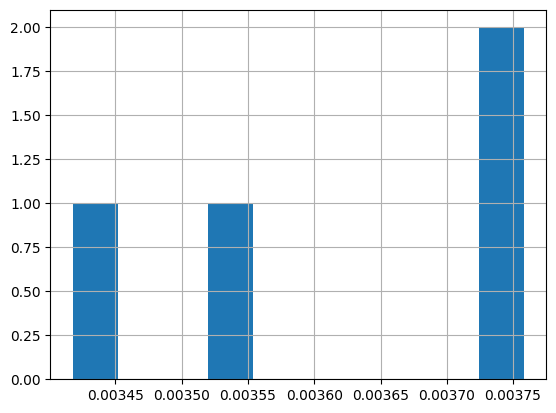

In [ ]:
df.loc[df['cv_score']<0.005, 'cv_score'].hist()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.loc[df['cv_score'] == df['cv_score'].min(), 'model'])

1    Sequential(\n  (0): Linear(in_features=12, out...
Name: model, dtype: object


In [ ]:
"Sequential(
  (0): Linear(in_features=12, out_features=9, bias=True)
  (sigmoid1): Sigmoid()
  (output): Linear(in_features=9, out_features=1, bias=True)
)";"SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)";0.1;25;1500;10;0.002717619203031063

In [ ]:
model = nn.Sequential(
    nn.Linear(12, 1),
    nn.ReLU(),
    nn.Linear(1, 1),)
    
loss_fn = nn.MSELoss()
batch_size=5
n_epochs = 1000
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
patience=10
batch_start = torch.arange(0, len(X_train), batch_size)

splitsize = np.int0(0.8*(len(X_train)))

X_train, X_val = X_train[:splitsize], X_train[splitsize:]
y_train, y_val = y_train[:splitsize], y_train[splitsize:]
best_mse = np.inf



# Training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        mse = loss_fn(y_pred, y_val).item()
    
    if mse < best_mse:
        best_mse = mse
        best_epoch = epoch
        
    elif epoch - best_epoch >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"Best validation MSE: {best_mse} at epoch {best_epoch}")

# Evaluate the model
model.eval()

# Evaluate on training data
with torch.no_grad():
    y_pred_train = model(X_train)
    mse_train = loss_fn(y_pred_train, y_train).item()

# Evaluate on test data
with torch.no_grad():
    y_pred_test = model(X_test)
    mse_test = loss_fn(y_pred_test, y_test).item()

print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 697.83batch/s] 

Best validation MSE: 23.626022338867188 at epoch 999
Train MSE: 22.582515716552734
Test MSE: 23.734018325805664
